In [1]:
import os
import re
from pathlib import Path

import pandas as pd
from census import Census
from dotenv import load_dotenv

from thompson import unvaccinated

load_dotenv()

True

In [2]:
# Directory containing unvaccinated people data

DATA_DIR = Path.cwd() / ".." / ".." / ".." / "data" / "unvax_data"
DEMO_DATA_DIR = Path.cwd() / ".." / ".." / ".." / "data" / "demographics"

ORIGINAL_FILES = [
    DATA_DIR / "input" / "unvax_contact_list_20210521_uniq_id.csv",
    DATA_DIR / "input" / "unvax_contact_list_20210601_uniq_id.csv",
    DATA_DIR / "input" / "unvax_contact_list_20210608_uniq_id.csv",
    DATA_DIR / "input" / "unvax_contact_list_20210622_uniq_id_updated.csv",
]

In [3]:
# Read in pure vaccination data
vax_df = pd.read_csv(DATA_DIR / "input" / "final_vax_list.csv")

# Note that this is _not_ unique by unique id
vax_df["unique_id"].value_counts().value_counts()

1       453675
2        54627
3         8669
4         1624
5          356
         ...  
1809         1
43           1
26           1
34           1
230          1
Name: unique_id, Length: 68, dtype: int64

In [4]:
# Fix types and verify that the file has the same
# orders of magnitude as the public file
vax_df["admin_date"] = pd.to_datetime(vax_df["admin_date"])
vax_df["admin_date"].value_counts()

2021-04-10    12563
2021-04-20    11180
2021-04-17    10182
2021-04-21     9866
2021-04-07     9328
              ...  
2021-06-20      220
2020-12-14      115
2021-01-01       81
2021-06-22        5
2020-12-25        1
Name: admin_date, Length: 191, dtype: int64

<AxesSubplot:xlabel='admin_date'>

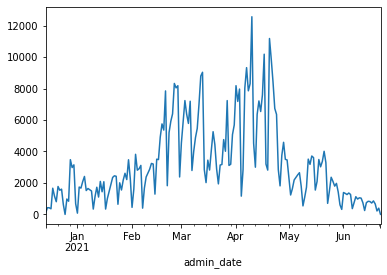

In [5]:
# Vaccinations by day
vax_df["admin_date"] = pd.to_datetime(vax_df["admin_date"])
vax_df.groupby("admin_date").size().sort_index().plot()

In [6]:
# Read data
dfs = []
for data_file in ORIGINAL_FILES:
    df = unvaccinated.read_unvaccinated_csv(data_file)
    the_date = pd.to_datetime(
        re.search(r"(\d{8})", data_file.stem).groups()[0],
        format="%Y%m%d",
    )

    df["record_date"] = the_date
    dfs.append(df)

df = pd.concat(dfs)

In [7]:
# There seems to be some volatility in the process that Zayid runs to
# determine who hasn't yet been vaccinated from the testing list. Note
# that below some people appear on the 5/21 list and not again until the
# 6/22 list. This _shouldn't_ be possible but here it is.
df.sort_values(by=["unique_id", "record_date"]).groupby("unique_id")[
    "record_date"
].apply(lambda x: tuple(sorted(frozenset(x)))).value_counts()

(2021-05-21 00:00:00, 2021-06-01 00:00:00, 2021-06-08 00:00:00, 2021-06-22 00:00:00)    129953
(2021-05-21 00:00:00, 2021-06-01 00:00:00, 2021-06-08 00:00:00)                           9006
(2021-05-21 00:00:00,)                                                                    7210
(2021-06-22 00:00:00,)                                                                    6667
(2021-05-21 00:00:00, 2021-06-08 00:00:00, 2021-06-22 00:00:00)                           5784
(2021-05-21 00:00:00, 2021-06-01 00:00:00)                                                5209
(2021-05-21 00:00:00, 2021-06-22 00:00:00)                                                3428
(2021-06-08 00:00:00, 2021-06-22 00:00:00)                                                2720
(2021-06-01 00:00:00, 2021-06-08 00:00:00, 2021-06-22 00:00:00)                           1852
(2021-05-21 00:00:00, 2021-06-08 00:00:00)                                                 985
(2021-06-08 00:00:00,)                            

In [8]:
date_df = df.groupby(["unique_id"]).agg(
    {"record_date": [("first_record_date", "min"), ("last_record_date", "max")]}
)

date_df.columns = date_df.columns.droplevel(0)

In [9]:
old_df = pd.concat(
    [
        pd.read_csv(DATA_DIR / "output" / "full-2021-05-25-for-week.csv"),
        pd.read_csv(DATA_DIR / "output" / "full-2021-06-02-for-week.csv"),
        pd.read_csv(DATA_DIR / "output" / "full-2021-06-09-for-week.csv"),
    ]
).rename(
    columns={
        "ContactId": "unique_id",
        "Groups": "assigned_message",
        "Tags": "message_language",
    }
)[
    [
        "unique_id",
        "assigned_message",
        "message_language",
        "date_sent",
        "is_chosen_from_uniform",
    ]
]

old_df["date_sent"] = pd.to_datetime(old_df["date_sent"])

In [10]:
# Remove the 249 Spanish language messages which were _assigned but not_ sent
# during the week of 2021-06-01
old_df = old_df[
    ~(
        (old_df["date_sent"] >= "2021-06-02")
        & (old_df["date_sent"] <= "2021-06-08")
        & (old_df["message_language"] == "Spanish")
    )
].copy()

In [11]:
# The process for merging vaccine information and our list:
# 1. Look at all records that were to receive a text message
# 2. Merge in all vaccination records
# 3. Verify that there is one message per unique_id
# 4. Create two flags:
#    * There is an administration after the text was sent and before 6/22
#    * There is an administration w/i one week of the date the message was
#      to be sent
merged_df = old_df.merge(vax_df, on="unique_id", how="left")

In [12]:
# Verify that there is one message per unique_id
merged_df.groupby("unique_id")["assigned_message"].nunique().value_counts()

1    158103
Name: assigned_message, dtype: int64

In [13]:
# Create the flags
merged_df["is_vax_after_send"] = merged_df["admin_date"].notna() & (
    merged_df["admin_date"] >= merged_df["date_sent"]
)

merged_df["is_within_one_week_after_send"] = merged_df["admin_date"].notna() & (
    (merged_df["admin_date"] >= merged_df["date_sent"])
    & (merged_df["admin_date"] < merged_df["date_sent"] + pd.Timedelta(days=7))
)

In [14]:
anytime_df = (
    merged_df.groupby(
        [
            "unique_id",
            "assigned_message",
            "message_language",
            "date_sent",
            "is_chosen_from_uniform",
        ]
    )["is_vax_after_send"]
    .any()
    .reset_index()
    .groupby(
        [
            "assigned_message",
            "message_language",
            "date_sent",
            "is_chosen_from_uniform",
            "is_vax_after_send",
        ]
    )
    .size()
    .reset_index(name="count")
)

anytime_df.to_csv(
    DATA_DIR / "output" / "counts_from_vax_list_anytime_after_send.csv", index=False
)

within_df = (
    merged_df.groupby(
        [
            "unique_id",
            "assigned_message",
            "message_language",
            "date_sent",
            "is_chosen_from_uniform",
        ]
    )["is_within_one_week_after_send"]
    .any()
    .reset_index()
    .groupby(
        [
            "assigned_message",
            "message_language",
            "date_sent",
            "is_chosen_from_uniform",
            "is_within_one_week_after_send",
        ]
    )
    .size()
    .reset_index(name="count")
)

within_df.to_csv(
    DATA_DIR / "output" / "counts_from_vax_list_within_one_week_after_send.csv",
    index=False,
)

In [15]:
within_df["is_within_one_week_after_send"].value_counts()

False    283
True     199
Name: is_within_one_week_after_send, dtype: int64

In [16]:
anytime_df["is_vax_after_send"].value_counts()

False    282
True     210
Name: is_vax_after_send, dtype: int64

### The old methogology using only RIDOH overall files

In [17]:
# Old methodology
final_df = date_df.merge(old_df, on="unique_id", how="left")
final_df["did_not_get_vaccinated"] = final_df["last_record_date"] == "2021-06-22"
final_df["eligible_for_text"] = final_df["first_record_date"] < "2021-06-22"

In [18]:
# Note that some people can not be assigned a message could be eligible for a text
# because they appeared on the list in (say) Week 1 but not in Week 2
(final_df["assigned_message"].notna() == final_df["eligible_for_text"]).mean()

0.9343987115652894

In [19]:
for_grouping = final_df.drop(columns="unique_id")
for_grouping.groupby(list(for_grouping), dropna=False).size().reset_index(
    name="count"
).to_csv(DATA_DIR / "output" / "final_counts_by_group.csv", index=False)

In [20]:
# Just double check that assigned message and date sent both come from the same list
(for_grouping["assigned_message"].notna() == for_grouping["date_sent"].notna()).all()

True

In [21]:
# Toplines?
1 - for_grouping.groupby(["assigned_message"]).did_not_get_vaccinated.mean()

assigned_message
message_0    0.110819
message_1    0.108055
message_2    0.114463
message_3    0.111553
message_4    0.110877
message_5    0.115509
message_6    0.086640
message_7    0.110081
message_8    0.110628
Name: did_not_get_vaccinated, dtype: float64

In [22]:
# What about positive versus negative tests
foo = df.sort_values(by=["unique_id", "record_date"]).drop_duplicates("unique_id")
foo = final_df.merge(foo[["unique_id", "test_result"]], on="unique_id")

(
    1
    - foo[foo["test_result"] == "positive"]
    .groupby("assigned_message")["did_not_get_vaccinated"]
    .mean()
)

assigned_message
message_0    0.140389
message_1    0.147818
message_2    0.156275
message_3    0.145424
message_4    0.150553
message_5    0.149378
message_6    0.116449
message_7    0.145387
message_8    0.152748
Name: did_not_get_vaccinated, dtype: float64

In [23]:
(
    1
    - foo[foo["test_result"] == "negative"]
    .groupby("assigned_message")["did_not_get_vaccinated"]
    .mean()
)

assigned_message
message_0    0.103875
message_1    0.098748
message_2    0.104680
message_3    0.103594
message_4    0.101549
message_5    0.107930
message_6    0.079701
message_7    0.101930
message_8    0.100779
Name: did_not_get_vaccinated, dtype: float64

In [24]:
# Check is_chosen_from_uniform numbers
# Bad issues with missing boolean types :-/
tmp_df = for_grouping[for_grouping["is_chosen_from_uniform"].notna()].copy()

tmp_df["is_chosen_from_uniform"] = tmp_df["is_chosen_from_uniform"].astype(bool)
tmp_df.groupby("date_sent")["is_chosen_from_uniform"].mean()

date_sent
2021-05-25    1.000000
2021-05-26    1.000000
2021-05-27    1.000000
2021-05-28    1.000000
2021-06-02    0.251102
2021-06-03    0.248331
2021-06-04    0.255284
2021-06-07    0.252959
2021-06-08    0.245559
2021-06-09    0.334460
2021-06-10    0.330123
2021-06-11    0.330251
2021-06-14    0.330378
2021-06-15    0.327400
Name: is_chosen_from_uniform, dtype: float64

### Add back in ZIP code data for demographics

In [25]:
with_zcta_df = (
    merged_df.groupby(
        [
            "unique_id",
            "assigned_message",
            "message_language",
            "date_sent",
            "is_chosen_from_uniform",
        ]
    )[["is_within_one_week_after_send", "is_vax_after_send"]]
    .any()
    .reset_index()
    .merge(
        df.sort_values(by="record_date").drop_duplicates("unique_id")[
            ["unique_id", "zcta"]
        ],
        on="unique_id",
        how="left",
    )
)

with_zcta_df.drop(columns=["unique_id"]).to_csv(
    DATA_DIR / "output" / "final_data_one_line_per_individual.csv", index=False
)

### Make sure all "New Methodology" data frames have the same counts

In [26]:
a_df = pd.read_csv(DATA_DIR / "output" / "final_data_one_line_per_individual.csv")

In [27]:
b_df = pd.read_csv(DATA_DIR / "output" / "counts_from_vax_list_within_one_week_after_send.csv")

In [28]:
assert (a_df.groupby(["assigned_message", "date_sent"]).size() == b_df.groupby(
    ["assigned_message", "date_sent"]
)["count"].sum()).all()

In [29]:
c_df = pd.read_csv(DATA_DIR / "output" / "counts_from_vax_list_anytime_after_send.csv")

In [30]:
assert (a_df.groupby(["assigned_message", "date_sent"]).size() == c_df.groupby(
    ["assigned_message", "date_sent"]
)["count"].sum()).all()